In [1]:
import pandas as pd
import glob
import os

In [2]:
# Chemin de base
base_path = '/Users/juleslefevre/Documents/SIAD/M2/MLOPS/tp_mlflow/data/batchs/'

# --- Pour le Restaurant 1 ---
# On cherche tout ce qui commence par 'restaurant_1_'
files_r1 = sorted(glob.glob(base_path + 'restaurant_1_*.csv'))
df_r1 = pd.concat((pd.read_csv(f) for f in files_r1), ignore_index=True)

# --- Pour le Restaurant 2 ---
# On cherche tout ce qui commence par 'restaurant_2_'
files_r2 = sorted(glob.glob(base_path + 'restaurant_2_*.csv'))
df_r2 = pd.concat((pd.read_csv(f) for f in files_r2), ignore_index=True)

print(f"Restaurant 1 : {df_r1.shape}")
print(f"Restaurant 2 : {df_r2.shape}")

Restaurant 1 : (74818, 6)
Restaurant 2 : (119183, 6)


# Méthode prof

In [3]:
!pip install loguru

In [4]:
import os
import pandas as pd
import numpy as np
from loguru import logger
import matplotlib.pyplot as plt

In [5]:
def extract_data(data_dir: str, prefix: str, start_week: int, end_week: int) -> pd.DataFrame:
    """Load and concat data between start_week and end_week
    """
    df = pd.DataFrame()
    logger.debug(f'Load data for {prefix} between week {start_week} and {end_week}')
    for i in range (start_week, end_week + 1):
        file_path = os.path.join(data_dir, 'batchs', f"{prefix}_week_{str(i).zfill(3)}.csv")
        if os.path.isfile(file_path):
            batch = pd.read_csv(file_path)
            df = pd.concat([df, batch], sort=True)
    logger.debug(f'Shape dataframe: {df.shape}')
    return df

In [6]:
df = extract_data(data_dir= '../data', prefix='restaurant_1', start_week=70, end_week=76)

2025-12-03 14:06:22.305 | DEBUG    | __main__:extract_data:5 - Load data for restaurant_1 between week 70 and 76
2025-12-03 14:06:22.335 | DEBUG    | __main__:extract_data:11 - Shape dataframe: (1525, 6)


In [7]:
df.head()

,Item Name,Order Date,Order Number,Product Price,Quantity,Total products
0,Red Sauce,2016-05-08 21:32:00,2856,0.5,1,6
1,Mint Sauce,2016-05-08 21:32:00,2856,0.5,1,6
2,Mint Sauce,2016-05-08 19:44:00,2852,0.5,1,2
3,Mint Sauce,2016-05-08 18:30:00,2849,0.5,2,9
4,Mango Chutney,2016-05-08 16:31:00,2843,0.5,1,6


In [8]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    """Basic data cleaning of dataset
    """
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df['order_date'] = pd.to_datetime(df['order_date'])
    df = df.rename(columns={'order_number': 'order_id'})
    df = df.sort_values('order_date')
    df['total_product_price'] = df['quantity'] * df['product_price']
    df['cash_in'] = df.groupby('order_id')['total_product_price'].transform('sum')
    df = df.drop(
        columns=[
            'item_name', 'quantity', 'product_price', 'total_products', 'total_product_price'
        ],
        errors='ignore'
    )
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    return df

In [9]:
df = clean(df)
df.head()

,order_date,order_id,cash_in
0,2016-05-04 18:45:00,2241,60.80
1,2016-05-04 21:22:00,2242,25.75
2,2016-05-05 19:02:00,2435,23.50
3,2016-05-05 19:03:00,2436,22.80
4,2016-05-05 19:19:00,2437,29.40


In [10]:
df1 = extract_data(data_dir = '../data', prefix='restaurant_1', start_week=74, end_week=76)
df2 = extract_data(data_dir = '../data', prefix='restaurant_2', start_week=74, end_week=76)
df1_clean = clean(df = df1)
df2_clean = clean(df = df2)

df = pd\
    .concat([df1_clean, df2_clean], sort=True)\
    .drop(columns = 'order_id')\
    .sort_values('order_date')\
    .reset_index(drop=True)

df_resample = df\
    .resample('1h', on='order_date')\
    .sum()\
    .reset_index()

df_resample\
    .sort_values('order_date')\
    .head()


2025-12-03 14:06:22.380 | DEBUG    | __main__:extract_data:5 - Load data for restaurant_1 between week 74 and 76
2025-12-03 14:06:22.385 | DEBUG    | __main__:extract_data:11 - Shape dataframe: (623, 6)
2025-12-03 14:06:22.385 | DEBUG    | __main__:extract_data:5 - Load data for restaurant_2 between week 74 and 76
2025-12-03 14:06:22.389 | DEBUG    | __main__:extract_data:11 - Shape dataframe: (1148, 6)


,order_date,cash_in
0,2016-05-30 10:00:00,73.65
1,2016-05-30 11:00:00,0.00
2,2016-05-30 12:00:00,0.00
3,2016-05-30 13:00:00,0.00
4,2016-05-30 14:00:00,0.00


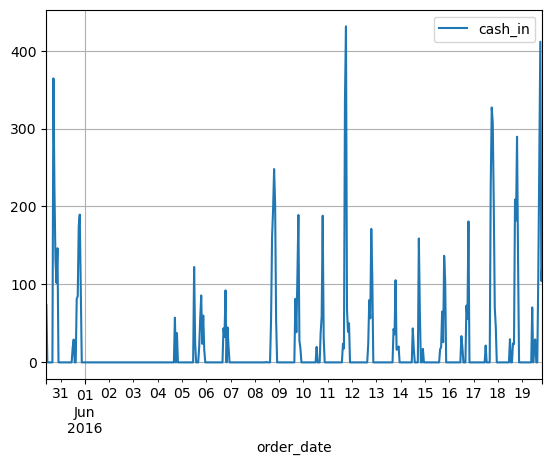

In [11]:
df_resample.sort_values('order_date').plot('order_date', 'cash_in')
plt.grid(True)